[View in Colaboratory](https://colab.research.google.com/github/dexterfichuk/U-Net-Keras-Implementation/blob/master/U-Net%20Implementation.ipynb)

# Paper Review: U-Net: Convolutional Networks for Biomedical Image Segmentation
*Dexter Fichuk*

The U-Net architecture is considered the standard of image segmentation for medical images. With variations winning numerous image segmentation Kaggle competitions, it is an extremely powerful architecture. It shines for training on small sets of data, where it's not easy to get many labeled images. This holds especially true for the medical discipline. The network relies heavily on the use of data augmentation to generate additional training data for the network and to prevent it from overfitting to a small training set. 

For this paper review, I wanted to implement the architecture described in the [original publication](https://arxiv.org/pdf/1505.04597.pdf). I'll be training the network on Google Colab, to leverage a high power GPU, instead of my MacBooks measly CPU. 

The architecture from the paper is visualized in the diagram below, and using this we will construct the network.
![U-Net Architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png =600x)
## Image Segmentation
Image segmentation is used in various fields, but it is creating a model that can draw the masks of certain objects in an image, instead of simply predicting which class the iamge belongs to. It means that for training data, you must have the input image, then a masked version of the input image where each pixel of the input is represented with the class that pixel belongs.

## Data Description
To evaluate our U-Net, I'll be training it on a set of blood vessels segmented in retina images. To really push the network, I'll be using only 15 images for the training set and 5 for our testing set. The preview of the train/test sets can be found [here](http://cecas.clemson.edu/~ahoover/stare/probing/index.html).

## Setup for Google Colab
Since Google Colab restarts the runtime every 12 hours, we'll put all the cod ein here we need to install additional libraries, and load in the data properly.

In [0]:
!rm -rf *


In [2]:
!pip install keras tqdm scikit-image

    100% |████████████████████████████████| 61kB 3.1MB/s 


Now we'll download our training data from http://cecas.clemson.edu/~ahoover/stare/probing/index.html, and unzip it to the proper directories that the code relies on.

In [3]:
!wget http://cecas.clemson.edu/~ahoover/stare/probing/stare-images.tar http://cecas.clemson.edu/~ahoover/stare/probing/labels-ah.tar

--2018-03-16 12:32:19--  http://cecas.clemson.edu/~ahoover/stare/probing/stare-images.tar
Resolving cecas.clemson.edu (cecas.clemson.edu)... 130.127.200.74
Connecting to cecas.clemson.edu (cecas.clemson.edu)|130.127.200.74|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18674176 (18M) [application/x-tar]
Saving to: ‘stare-images.tar’

stare-images.tar    100%[===================>]  17.81M  23.2MB/s    in 0.8s    

2018-03-16 12:32:21 (23.2 MB/s) - ‘stare-images.tar’ saved [18674176/18674176]

--2018-03-16 12:32:21--  http://cecas.clemson.edu/~ahoover/stare/probing/labels-ah.tar
Reusing existing connection to cecas.clemson.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 241664 (236K) [application/x-tar]
Saving to: ‘labels-ah.tar’

labels-ah.tar       100%[===================>] 236.00K  --.-KB/s    in 0.003s  

2018-03-16 12:32:21 (66.9 MB/s) - ‘labels-ah.tar’ saved [241664/241664]

FINISHED --2018-03-16 12:32:21--
Total wall clock time: 1.2s
Downl

In [0]:
!rm -rf data/

In [0]:
!mkdir -p data/retina/input
!mkdir -p data/retina/masks

In [0]:
!tar -xf labels-ah.tar -C data/retina/masks/
!tar -xf stare-images.tar -C data/retina/input/

In [0]:
!find data/retina/input/ -name '*.gz' -exec gunzip '{}' \;
!find data/retina/masks/ -name '*.gz' -exec gunzip '{}' \;

In [8]:
!ls data/retina/masks

im0001.ah.ppm  im0005.ah.ppm  im0082.ah.ppm  im0235.ah.ppm  im0255.ah.ppm
im0002.ah.ppm  im0044.ah.ppm  im0139.ah.ppm  im0236.ah.ppm  im0291.ah.ppm
im0003.ah.ppm  im0077.ah.ppm  im0162.ah.ppm  im0239.ah.ppm  im0319.ah.ppm
im0004.ah.ppm  im0081.ah.ppm  im0163.ah.ppm  im0240.ah.ppm  im0324.ah.ppm


In [9]:
!ls data/retina/input

im0001.ppm  im0005.ppm	im0082.ppm  im0235.ppm	im0255.ppm
im0002.ppm  im0044.ppm	im0139.ppm  im0236.ppm	im0291.ppm
im0003.ppm  im0077.ppm	im0162.ppm  im0239.ppm	im0319.ppm
im0004.ppm  im0081.ppm	im0163.ppm  im0240.ppm	im0324.ppm


In [10]:
!ls

data  labels-ah.tar  stare-images.tar


In [11]:
!ls

data  labels-ah.tar  stare-images.tar


In [0]:
!rm -rf stage1_train.zip stare-images.tar

## Implementation

To implement the U-Net, I'm going to use Keras because it is powerful, and I the fastest way for me to create it. 

In [13]:
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, merge, Input, Cropping2D, Dropout, Lambda
from keras.layers.merge import concatenate
from keras.optimizers import *
from keras.models import *
import keras.backend as K
from keras.losses import binary_crossentropy

Using TensorFlow backend.


In [0]:
# Set the dimensions for our images to be resized to
width, height = 256, 256

### Metrics
Unlike a normal binary prediction where we use binary_crossentropy for loss and accuracy for our metric, we need to use some alternate metrics. This is because instead of prediciton a single output variable, we are predicting an output class for every single pixel (image segmentation). To evaluate the model, we'll use the following custom metrics:
- BCE Dice Loss used as loss function.
- Jaccard Coefficient used to calculate intersection over union (accuracy)

In [0]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
  
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

smooth = 1e-12

def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

In [0]:
# To be changed if needing to crop network for different sized images
pad = 'same'

### Model
Using the dagram from the U-Net paper, we'll implement the same architecture with identical parameters.

In [0]:
def create_unet(lr = 1e-4):
  # First downsampling block
  # 64 filters for output
  # filter size of 3 specifies a 3x3 sliding convolution window
  # he_normal used to initialize gaussian distributed random weights (recommended form U-Net paper)
  
  inputs = Input(shape=(width, height, 3))
  # This lambda scales the input from the RGB range of 0-255, to be between 0 and 1.
  s = Lambda(lambda x: x / 255) (inputs)
  
  # first conv layers
  conv1 = Conv2D(64, 3, activation = 'relu', padding=pad, kernel_initializer='he_normal') (s)
  conv1 = Conv2D(64, 3, activation = 'relu', padding=pad, kernel_initializer='he_normal') (conv1)

  # Downsampling
  pool1 = MaxPool2D(pool_size=(2,2), padding=pad) (conv1)

  # Second downsampling block
  conv2 = Conv2D(128, 3, activation='relu', padding=pad, kernel_initializer='he_normal') (pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding=pad, kernel_initializer='he_normal') (conv2)
  pool2 = MaxPool2D(pool_size=(2, 2), padding = pad) (conv2)

  # Third downsampling block
  conv3 = Conv2D(256, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(conv3)
  pool3 = MaxPool2D(pool_size=(2, 2), padding=pad) (conv3)

  # Fourth downsampling block
  conv4 = Conv2D(512, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(conv4)

  # Dropout added to final downsamples
  drop4 = Dropout(0.0)(conv4)
  pool4 = MaxPool2D(pool_size=(2, 2), padding=pad) (drop4)

  conv5 = Conv2D(1024, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(conv5)
  # Final dropout
  drop5 = Dropout(0.0)(conv5)


  # Upsample 1
  up1 = UpSampling2D(size=(2, 2)) (drop5)
  up1 = concatenate([conv4, up1], axis=3)
  upconv1 = Conv2D(512, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(up1)
  upconv1 = Conv2D(512, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(upconv1)

  up2 = UpSampling2D(size=(2, 2)) (upconv1)
  up2 = concatenate([conv3, up2], axis=3)
  upconv2 = Conv2D(256, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(up2)
  upconv2 = Conv2D(256, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(upconv2)

  up3 = UpSampling2D(size=(2, 2)) (upconv2)
  up3 = concatenate([conv2, up3], axis=3)
  upconv3 = Conv2D(128, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(up3)
  upconv3 = Conv2D(128, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(upconv3)

  up4 = UpSampling2D(size=(2, 2)) (upconv3)
  up4 = concatenate([conv1, up4], axis=3)
  upconv4 = Conv2D(64, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(up4)
  upconv4 = Conv2D(64, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(upconv4)
  # removed because of some glitches, but should maybe be used?
#   upconv4 = Conv2D(2, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(upconv4)
  outconv = Conv2D(1, 1, activation='sigmoid')(upconv4)
  
  model = None
  model = Model(inputs = inputs, outputs = outconv)
  model.compile(optimizer=Adam(lr = lr), loss=bce_dice_loss, metrics=[jaccard_coef])
  return model

Now let's print a summary of our U-Net model! This can be super useful for debugging the model when training, getting an idea of the output dimensionality of each layer, and seeing where layers are joined together.

In [18]:
create_unet().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

Our model has over a whopping 30 million parameters to train! It's fair to say this is a very deep neural network that would be nearly impossible to train on a CPU based machine.

## Loading Data
The dataset we'll be using is a segmentation set for the blood vessel's in a retina. To really bush the boundaries of a U-Net, I'm only going to train the model on 15 training images, the complete opposite of big data. We'll then use 5 images for our validation dataset. The claim in the paper is that through using data augmentation, and the u-net architecture, we shoudl be able to train a high quality model!

In [0]:
import numpy as np
import os
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import tqdm
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Our seed to keep our models results reproducable
seed = 42

# Get the ID's of all the images by walking through the directory
train_ids = next(os.walk('data/retina/input'))[2]
train_ids = [i.replace(".ppm", "") for i in train_ids]

In [0]:
# Load in the images and masks, and then resize them to our defined dimensions
X, y = [], []

for id_ in train_ids:
#     path = TRAIN_PATH + id_
    img = imread('data/retina/input/' + id_ + '.ppm')[:,:,:3]
    img = resize(img, (height, width), mode='constant', preserve_range=True)
    X.append(img)
    
    mask = np.zeros((height, width, 1), dtype=np.bool)
    
    
    mask_ = imread('data/retina/masks/' + id_ + ".ah.ppm")
    mask_ = np.expand_dims(resize(mask_, (height, width), mode='constant'), axis=-1)
    mask = np.maximum(mask, mask_)
    y.append(mask)

X, y = np.asarray(X), np.asarray(y)

Now we'll preview the what an input image looks like, and it's corresponding mask.

Input Image


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


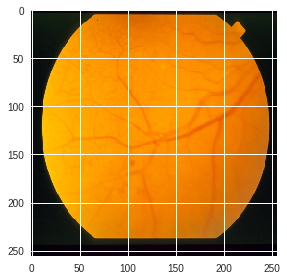

Target Mask


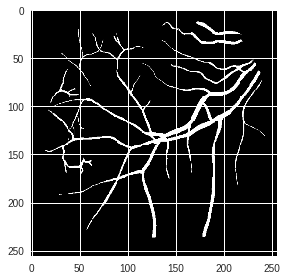

In [21]:
# Check if training data looks okay
print("Input Image")
ix = random.randint(0, len(train_ids)-1)
imshow(X[ix]/255)
plt.show()
print("Target Mask")
imshow(np.squeeze(y[ix]))
plt.show()

You can tell that since we've reduced the images from their original size of 700x605 to 256x256 we've lost a bit of the lines. However, this is a fair tradeoff as our model will have a much faster time training on these smaller images. Since we're also resizing all the images to the same size, we don't have to worry about adding special cropping to our U-Net architecture, although it is capable of handling training images of different sizes.

In [22]:
# Split our data into training and testing sets
X_train, X_test, y_train, y_test = X[:15], X[15:], y[:15], y[15:]
print("Num Train:", len(X_train))
print("Num Test:", len(X_test))

Num Train: 15
Num Test: 5


## Data Augmentation
The U-Net is optimized for data augmentation, as highlighted in the paper. So we will define a image data generator that will perform multiple transformations to out training data. Using keras built-in ImageDataGenerator, we can set different transformations that the model will randomly perform to our training data to create more. This is used for improving the model, and it highly decreases the chances of overfitting because the model is constantly seeing different examples. For our generator, we'll apply some simple transformations, allowing the zoom range to be 20% of the original image, the sheet range to also be 20%, and we'll allow the images to be flipped horizontal.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Define our transformations
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

mask_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


BATCH_SIZE = 6

# Keep the same seed for image and mask generators so they fit together

train_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

X_gen = train_datagen.flow(X_train,batch_size=BATCH_SIZE, seed=seed)
y_gen = mask_datagen.flow(y_train,batch_size=BATCH_SIZE, seed=seed)


In [0]:
#creating a training and validation generator that generate masks and images
train_generator = zip(X_gen, y_gen)

Now that our data generator is fitted to our training data, let's preview some of the variants it creates.

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


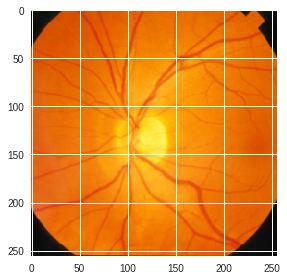

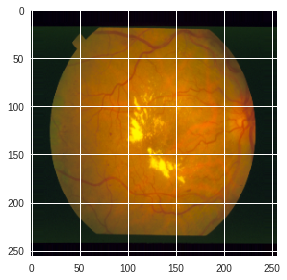

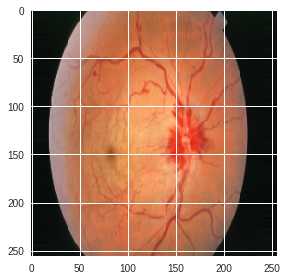

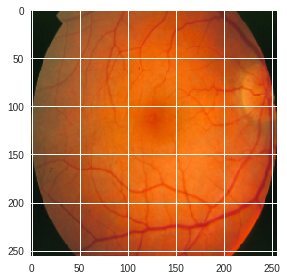

In [25]:
# Print some generated images
for X_batch, y_batch in train_datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
  for i in range(0, 4):
    imshow(X_batch[i]/255)    
	# show the plot
    plt.show()
  break

Great, everything looks good with these images so it's time to move onto our training!

## Training

We'll first load in an instance of our model, and we'll start with a bit higher of a learning rate of 0.001.

In [0]:
model = create_unet(lr = 1e-3)

Now I'm going to add 3 different callbacks to our model. Callbacks are functions that are run after each epoch of training, and can influence the future training of our model. The callbacks work as follows:
- The EarlyStopper can terminate our model earlier than our full set number of epochs. All we have to do is set the patience to a number, and if the validation loss hasn't improved in that many epochs, our training will terminate as we're likely overfitting.
- The ModelCheckpoint will save the weights of our model after each epoch if the validation loss has improved. This means, even if we've continued to train our model and overfit it, we'll only save the last copy that had improved the validation loss, which can then be loaded in afterwards. This allows us to set a higher patience for the early stopper because we know even if we overfit, we'll just load back the best val weights.
- Lastly, the ReduceLROnPlateau will reduce the models learning rate by a set factor if the validation loss hasn't increased in a certain number of epochs. Typically, when a model is starting to reach it's highest achievable accuracy, reducing the learning rate can help make more fine tuned changes without damaging the model.

In [0]:
# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Fit model
earlystopper = EarlyStopping(patience=12, verbose=1)

checkpointer = ModelCheckpoint('model-retina-unet.h5', verbose=2, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00005, verbose = 1)

Fianlly, we'll train our model with keras fit_generator. The fit_generator allows us to use our data generator for training. We'll then do a low number of steps_per_epoch because we're only generating 6 images for each epoch. We'll then allow our model to train for 100 epochs, and at the end of each epoch have it evaluate on the testing set of data. We don't want to apply any augmentations to our test set because we want it to be the same consisten set for each epoch.

In [28]:
model.fit_generator(train_generator, steps_per_epoch=10, epochs = 100, 
                    validation_data=(X_test, y_test), verbose=1,
                    callbacks=[earlystopper, checkpointer, reduce_lr])

Epoch 1/100
10/10 [==============================] - 23s 2s/step - loss: 2.6910 - jaccard_coef: 0.0403 - val_loss: 1.2805 - val_jaccard_coef: 0.0539

Epoch 00001: val_loss improved from inf to 1.28052, saving model to model-retina-unet.h5
Epoch 2/100
10/10 [==============================] - 10s 987ms/step - loss: 1.2176 - jaccard_coef: 0.0545 - val_loss: 1.1243 - val_jaccard_coef: 0.0643

Epoch 00002: val_loss improved from 1.28052 to 1.12435, saving model to model-retina-unet.h5
Epoch 3/100
10/10 [==============================] - 10s 1s/step - loss: 1.1235 - jaccard_coef: 0.0726 - val_loss: 1.0894 - val_jaccard_coef: 0.0712

Epoch 00003: val_loss improved from 1.12435 to 1.08937, saving model to model-retina-unet.h5
Epoch 4/100
10/10 [==============================] - 10s 986ms/step - loss: 1.0973 - jaccard_coef: 0.0771 - val_loss: 1.0633 - val_jaccard_coef: 0.0791

Epoch 00004: val_loss improved from 1.08937 to 1.06332, saving model to model-retina-unet.h5
Epoch 5/100
10/10 [=======

10/10 [==============================] - 10s 960ms/step - loss: 1.0097 - jaccard_coef: 0.1230 - val_loss: 0.8682 - val_jaccard_coef: 0.1641

Epoch 00009: val_loss improved from 0.98785 to 0.86821, saving model to model-retina-unet.h5
Epoch 10/100
10/10 [==============================] - 10s 987ms/step - loss: 1.0015 - jaccard_coef: 0.1387 - val_loss: 0.8680 - val_jaccard_coef: 0.1627

Epoch 00010: val_loss improved from 0.86821 to 0.86800, saving model to model-retina-unet.h5
Epoch 11/100
10/10 [==============================] - 10s 986ms/step - loss: 0.9448 - jaccard_coef: 0.1620 - val_loss: 0.8006 - val_jaccard_coef: 0.2147

Epoch 00011: val_loss improved from 0.86800 to 0.80065, saving model to model-retina-unet.h5
Epoch 12/100
10/10 [==============================] - 10s 957ms/step - loss: 0.9618 - jaccard_coef: 0.1656 - val_loss: 0.8559 - val_jaccard_coef: 0.1878

Epoch 00012: val_loss did not improve
Epoch 13/100
10/10 [==============================] - 10s 988ms/step - loss: 0.9

10/10 [==============================] - 10s 986ms/step - loss: 0.9343 - jaccard_coef: 0.2170 - val_loss: 0.7841 - val_jaccard_coef: 0.2250

Epoch 00017: val_loss did not improve
Epoch 18/100
10/10 [==============================] - 10s 957ms/step - loss: 0.8787 - jaccard_coef: 0.1921 - val_loss: 0.7520 - val_jaccard_coef: 0.2280

Epoch 00018: val_loss did not improve
Epoch 19/100
10/10 [==============================] - 10s 991ms/step - loss: 0.7510 - jaccard_coef: 0.2463 - val_loss: 0.7019 - val_jaccard_coef: 0.2808

Epoch 00019: val_loss improved from 0.73288 to 0.70187, saving model to model-retina-unet.h5
Epoch 20/100
10/10 [==============================] - 10s 987ms/step - loss: 0.7932 - jaccard_coef: 0.2575 - val_loss: 0.6432 - val_jaccard_coef: 0.3077

Epoch 00020: val_loss improved from 0.70187 to 0.64316, saving model to model-retina-unet.h5
Epoch 21/100
10/10 [==============================] - 10s 958ms/step - loss: 0.7366 - jaccard_coef: 0.2809 - val_loss: 0.7605 - val_jac

10/10 [==============================] - 10s 990ms/step - loss: 0.6406 - jaccard_coef: 0.3515 - val_loss: 0.5579 - val_jaccard_coef: 0.3837

Epoch 00025: val_loss improved from 0.58288 to 0.55786, saving model to model-retina-unet.h5
Epoch 26/100
10/10 [==============================] - 10s 986ms/step - loss: 0.6228 - jaccard_coef: 0.3686 - val_loss: 0.5869 - val_jaccard_coef: 0.3664

Epoch 00026: val_loss did not improve
Epoch 27/100
10/10 [==============================] - 10s 956ms/step - loss: 0.6237 - jaccard_coef: 0.3767 - val_loss: 0.5371 - val_jaccard_coef: 0.3879

Epoch 00027: val_loss improved from 0.55786 to 0.53709, saving model to model-retina-unet.h5
Epoch 28/100
10/10 [==============================] - 10s 986ms/step - loss: 0.6558 - jaccard_coef: 0.3424 - val_loss: 0.5512 - val_jaccard_coef: 0.3923

Epoch 00028: val_loss did not improve
Epoch 29/100
10/10 [==============================] - 10s 987ms/step - loss: 0.6272 - jaccard_coef: 0.3602 - val_loss: 0.5312 - val_jac


Epoch 00033: val_loss improved from 0.52012 to 0.50953, saving model to model-retina-unet.h5
Epoch 34/100
10/10 [==============================] - 10s 986ms/step - loss: 0.5820 - jaccard_coef: 0.3960 - val_loss: 0.5051 - val_jaccard_coef: 0.4214

Epoch 00034: val_loss improved from 0.50953 to 0.50508, saving model to model-retina-unet.h5
Epoch 35/100
10/10 [==============================] - 10s 982ms/step - loss: 0.5727 - jaccard_coef: 0.4010 - val_loss: 0.5082 - val_jaccard_coef: 0.4217

Epoch 00035: val_loss did not improve
Epoch 36/100
10/10 [==============================] - 10s 959ms/step - loss: 0.5777 - jaccard_coef: 0.4130 - val_loss: 0.5070 - val_jaccard_coef: 0.4183

Epoch 00036: val_loss did not improve
Epoch 37/100
10/10 [==============================] - 10s 986ms/step - loss: 0.5623 - jaccard_coef: 0.4176 - val_loss: 0.5063 - val_jaccard_coef: 0.4275

Epoch 00037: val_loss did not improve
Epoch 38/100
10/10 [==============================] - 10s 985ms/step - loss: 0.5691

10/10 [==============================] - 10s 959ms/step - loss: 0.5629 - jaccard_coef: 0.4194 - val_loss: 0.4998 - val_jaccard_coef: 0.4145

Epoch 00042: val_loss did not improve
Epoch 43/100
10/10 [==============================] - 10s 987ms/step - loss: 0.5567 - jaccard_coef: 0.4268 - val_loss: 0.4936 - val_jaccard_coef: 0.4358

Epoch 00043: val_loss did not improve
Epoch 44/100
10/10 [==============================] - 10s 987ms/step - loss: 0.5543 - jaccard_coef: 0.4254 - val_loss: 0.4804 - val_jaccard_coef: 0.4469

Epoch 00044: val_loss improved from 0.48068 to 0.48041, saving model to model-retina-unet.h5
Epoch 45/100
10/10 [==============================] - 10s 956ms/step - loss: 0.5537 - jaccard_coef: 0.4293 - val_loss: 0.4793 - val_jaccard_coef: 0.4359

Epoch 00045: val_loss improved from 0.48041 to 0.47934, saving model to model-retina-unet.h5
Epoch 46/100
10/10 [==============================] - 10s 986ms/step - loss: 0.5517 - jaccard_coef: 0.4186 - val_loss: 0.4861 - val_jac

10/10 [==============================] - 10s 956ms/step - loss: 0.5287 - jaccard_coef: 0.4475 - val_loss: 0.4741 - val_jaccard_coef: 0.4385

Epoch 00051: val_loss improved from 0.47934 to 0.47413, saving model to model-retina-unet.h5
Epoch 52/100
10/10 [==============================] - 10s 986ms/step - loss: 0.5334 - jaccard_coef: 0.4387 - val_loss: 0.4652 - val_jaccard_coef: 0.4554

Epoch 00052: val_loss improved from 0.47413 to 0.46515, saving model to model-retina-unet.h5
Epoch 53/100
10/10 [==============================] - 10s 982ms/step - loss: 0.5209 - jaccard_coef: 0.4461 - val_loss: 0.4732 - val_jaccard_coef: 0.4479

Epoch 00053: val_loss did not improve
Epoch 54/100
10/10 [==============================] - 10s 956ms/step - loss: 0.5187 - jaccard_coef: 0.4461 - val_loss: 0.4740 - val_jaccard_coef: 0.4431

Epoch 00054: val_loss did not improve
Epoch 55/100
10/10 [==============================] - 10s 988ms/step - loss: 0.5177 - jaccard_coef: 0.4507 - val_loss: 0.4542 - val_jac

10/10 [==============================] - 10s 986ms/step - loss: 0.5126 - jaccard_coef: 0.4445 - val_loss: 0.4574 - val_jaccard_coef: 0.4597

Epoch 00059: val_loss did not improve
Epoch 60/100
10/10 [==============================] - 10s 955ms/step - loss: 0.5104 - jaccard_coef: 0.4534 - val_loss: 0.4611 - val_jaccard_coef: 0.4540

Epoch 00060: val_loss did not improve
Epoch 61/100
10/10 [==============================] - 10s 987ms/step - loss: 0.5026 - jaccard_coef: 0.4677 - val_loss: 0.4672 - val_jaccard_coef: 0.4506

Epoch 00061: val_loss did not improve

Epoch 00061: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 62/100
10/10 [==============================] - 10s 986ms/step - loss: 0.5046 - jaccard_coef: 0.4533 - val_loss: 0.4525 - val_jaccard_coef: 0.4671

Epoch 00062: val_loss did not improve
Epoch 63/100
10/10 [==============================] - 10s 957ms/step - loss: 0.4934 - jaccard_coef: 0.4640 - val_loss: 0.4566 - val_jaccard_coef: 0.4630

Epoch 0006

10/10 [==============================] - 10s 987ms/step - loss: 0.4813 - jaccard_coef: 0.4756 - val_loss: 0.4366 - val_jaccard_coef: 0.4783

Epoch 00067: val_loss did not improve
Epoch 68/100
10/10 [==============================] - 10s 989ms/step - loss: 0.4875 - jaccard_coef: 0.4694 - val_loss: 0.4341 - val_jaccard_coef: 0.4801

Epoch 00068: val_loss improved from 0.43629 to 0.43408, saving model to model-retina-unet.h5
Epoch 69/100
10/10 [==============================] - 10s 953ms/step - loss: 0.4778 - jaccard_coef: 0.4739 - val_loss: 0.4395 - val_jaccard_coef: 0.4692

Epoch 00069: val_loss did not improve
Epoch 70/100
10/10 [==============================] - 10s 988ms/step - loss: 0.4744 - jaccard_coef: 0.4824 - val_loss: 0.4334 - val_jaccard_coef: 0.4803

Epoch 00070: val_loss improved from 0.43408 to 0.43337, saving model to model-retina-unet.h5
Epoch 71/100
10/10 [==============================] - 10s 985ms/step - loss: 0.4668 - jaccard_coef: 0.4813 - val_loss: 0.4299 - val_jac


Epoch 00075: val_loss improved from 0.42609 to 0.42367, saving model to model-retina-unet.h5
Epoch 76/100
10/10 [==============================] - 10s 987ms/step - loss: 0.4691 - jaccard_coef: 0.4846 - val_loss: 0.4198 - val_jaccard_coef: 0.4860

Epoch 00076: val_loss improved from 0.42367 to 0.41981, saving model to model-retina-unet.h5
Epoch 77/100
10/10 [==============================] - 10s 984ms/step - loss: 0.4610 - jaccard_coef: 0.4911 - val_loss: 0.4153 - val_jaccard_coef: 0.4896

Epoch 00077: val_loss improved from 0.41981 to 0.41532, saving model to model-retina-unet.h5
Epoch 78/100
10/10 [==============================] - 10s 955ms/step - loss: 0.4580 - jaccard_coef: 0.4829 - val_loss: 0.4129 - val_jaccard_coef: 0.4853

Epoch 00078: val_loss improved from 0.41532 to 0.41286, saving model to model-retina-unet.h5
Epoch 79/100
10/10 [==============================] - 10s 987ms/step - loss: 0.4617 - jaccard_coef: 0.4995 - val_loss: 0.4180 - val_jaccard_coef: 0.4915

Epoch 00079

10/10 [==============================] - 10s 958ms/step - loss: 0.4475 - jaccard_coef: 0.5051 - val_loss: 0.4238 - val_jaccard_coef: 0.4804

Epoch 00084: val_loss did not improve
Epoch 85/100
10/10 [==============================] - 10s 988ms/step - loss: 0.4502 - jaccard_coef: 0.4993 - val_loss: 0.4187 - val_jaccard_coef: 0.4926

Epoch 00085: val_loss did not improve

Epoch 00085: ReduceLROnPlateau reducing learning rate to 5e-05.
Epoch 86/100
10/10 [==============================] - 10s 991ms/step - loss: 0.4525 - jaccard_coef: 0.4943 - val_loss: 0.4257 - val_jaccard_coef: 0.4867

Epoch 00086: val_loss did not improve
Epoch 87/100
10/10 [==============================] - 10s 959ms/step - loss: 0.4503 - jaccard_coef: 0.5007 - val_loss: 0.4228 - val_jaccard_coef: 0.4829

Epoch 00087: val_loss did not improve
Epoch 88/100
10/10 [==============================] - 10s 988ms/step - loss: 0.4435 - jaccard_coef: 0.4888 - val_loss: 0.4183 - val_jaccard_coef: 0.4917

Epoch 00088: val_loss did 

We can see that our callbacks consistintly saves the models weights when val loss improved, it reduced the learning rate when their wasn't any improvements for a few epochs, and terminated early because it wasn't seeing any progress. We'll now load back in the last saved weights to have the best version of the model.

In [0]:
from keras.models import load_model
# Have to load back in custom loss and metrics with the models weights
model = load_model("model-retina-unet.h5", custom_objects=({'bce_dice_loss': bce_dice_loss, 
                                                            'jaccard_coef': jaccard_coef}))

### Saving Model Weights to Google Drive
*Is a whopping 350MB*

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [32]:
f = drive.CreateFile()
f.SetContentFile('model-retina-unet.h5')
f.Upload()
print('title: %s, mimeType: %s' % (f['title'], f['mimeType']))

title: model-retina-unet.h5, mimeType: application/octet-stream


## Evaluation

Now, let's preview one of our models predictions against the actual labels using an image from our test set that the model was not trained on!

In [0]:
y_pred = model.predict(X_test)

Original Image


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


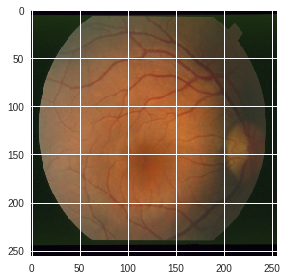

Ground Truth


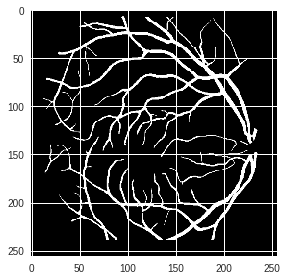

Prediction


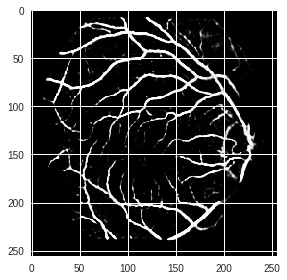

In [31]:
test_ind = 1

print("Original Image")
imshow(X_test[test_ind]/255)
plt.show()
print("Ground Truth")
imshow(np.squeeze(y_test[test_ind]))
plt.show()
print("Prediction")
imshow(np.squeeze(y_pred[test_ind]))
plt.show()

We'll try just anohter test image to play it safe.


Original Image


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


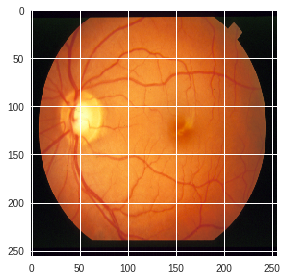

Ground Truth


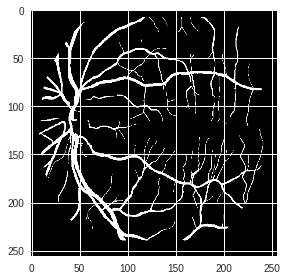

Prediction


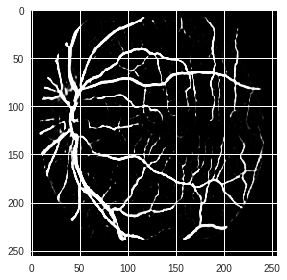

In [32]:
test_ind = 3

print("Original Image")
imshow(X_test[test_ind]/255)
plt.show()
print("Ground Truth")
imshow(np.squeeze(y_test[test_ind]))
plt.show()
print("Prediction")
imshow(np.squeeze(y_pred[test_ind]))
plt.show()

Interestingly enough, we can actually see that our model performs smoothing of the vessels compared to the shrunk target masks. But we can see how precise our U-net's predictions are!

## References
- https://arxiv.org/pdf/1505.04597.pdf
- http://cecas.clemson.edu/~ahoover/stare/probing/index.html